## Do the tradeoff curves look different for arbitrary distributions of cargo:

* We set each compartment to have a length of 8 microns. Since there are 100 compartments, this results in a 800 micron cable, which is roughly the length of an apical dendrite for a typical pyramidal neuron.
* We examined the effect of manipulating the velocity at the soma within experimentally measured ranges. We report these velocities in $\mu$m per minute; however, we simulate the model in units of seconds.
* The trafficking rates are constrained so that $a+b=1$, which means that the variance in position increases at a rate of 1 compartment size per second (8 $\mu m^2$ per second, see code/notebook for figure 1).
    * This has the following interpretation: if we start with a delta function of cargo as an initial condition, then after one second, the distribution of cargo should have a standard deviation of $\sqrt{8} \approx 2.8 \mu m$.
    * This is a conservative estimate, nearly an order of magnitude larger than the diffusion coefficient used in figure 1. Nevertheless, the tradeoff between speed and precision is severe.


In [5]:
from __future__ import division
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import expm # matrix exponential solves linear system
from scipy.signal import convolve,gaussian
import pylab as plt
%matplotlib inline

N = 100 # Number of compartments

def get_target(profile):
    if profile == 'unif':
        y = np.ones(N)/N
    elif profile == 'prox':
        y = np.ones(N)
        y[:int(N/2)]*= 10
        y /= np.sum(y)
    elif profile == 'dist':
        y = np.ones(N)
        y[int(N/2):]*= 10
        y /= np.sum(y)
    return y

def get_matrix(timescale,bias,diff_coeff=1.0,profile='unif'):
    # detachment rates
    y = get_target(profile)
    c = timescale*y
    
    # trafficking rates, constrain so that a+b = 1
    a = np.linspace((diff_coeff/2)+bias,(diff_coeff/2),N-1)
    b = np.linspace((diff_coeff/2)-bias,(diff_coeff/2),N-1)
        
    mid = -c
    mid[:-1] -= a
    mid[1:]  -= b
    A1 = np.diag(a, -1) + np.diag(mid) + np.diag(b, 1) # Upper-right block
    A2 = np.diag(c) # Lower-left block
    
    # State-transition matrix
    A = np.bmat([[A1,np.zeros((N,N))],[A2,np.zeros((N,N))]])
    
    # initial condition
    u0 = np.zeros(2*N)
    u0[0] = 1.0
    
    return A,u0,y

def plot_steady_state(A):
    uss = np.dot(expm(A*1e10),u0) # steady-state profile
    
    plt.figure()
    plt.title('steady-state concentration')
    plt.plot(np.linspace(0,1,N),y/np.sum(y),'-k',lw=2)
    plt.plot(np.linspace(0,1,N),uss[N:],'-r',lw=2)
    #plt.ylim([-0.02,1.3]),plt.xlim([0,1])
    plt.legend(('target','steady-state'))
    plt.tight_layout()
    plt.show()

def calc_tradeoff_curve(bias=0.0,npts=3,diff_coeff=1.0,profile='unif'):
    tau,err = [],[]
    for timescale in np.logspace(-3,0,npts):
        A,u0,y = get_matrix(timescale,bias,diff_coeff=diff_coeff,profile=profile)
        tss = calc_timescale(A)
        uss = np.dot(expm(A*1e2*tss),u0) # steady-state profile
        err.append(100*np.mean(np.abs((y-uss[N:])/y)))
        tau.append(tss)
    return np.array(tau),np.array(err)

def calc_timescale(A,perc_error=0.05,tol=1.0):
    # calculate number of seconds to reach steady-state (within perc_error)
    u0 = np.ones(N*2)
    u0[0] = 1.0
    
    upper_bound = 1e10
    lower_bound = 0
    while (upper_bound-lower_bound)>tol:
        tt = lower_bound + (upper_bound-lower_bound)/2
        u = np.dot(expm(A*tt),u0)
        if np.sum(u[:N]) > perc_error:
            # not converged to steady-state
            lower_bound = tt
        else:
            # converged to steady-state
            upper_bound = tt
        #print lower_bound,upper_bound
        #sleep(1.0)
    return lower_bound + (upper_bound-lower_bound)/2

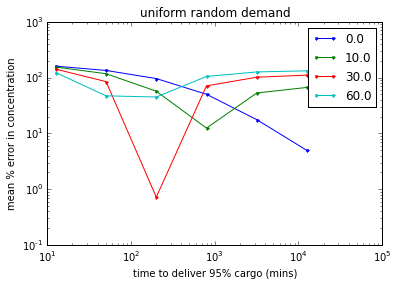

In [6]:
# Velocities at the soma (microns per minute)
velocities = [0.0,10.0,30.0,60.0]

# Size of each compartment in microns
cs = 8

# Compute bias terms
# /60 to convert seconds to minutes
# /cs the compartment size in microns
# /2 since velocity = a-b = (0.5+bias)-(0.5-bias) = 2*bias
bias_levels = [velocities[i]/60/cs/2 for i in range(len(velocities))]

plt.figure()
for bias in bias_levels:
    tau,err = calc_tradeoff_curve(bias=bias,npts=6,diff_coeff=0.5)
    plt.plot(tau/60,err,'.-')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e1,1e5])
#plt.ylim([1e0,1e3])
plt.xlabel('time to deliver 95% cargo (mins)')
plt.ylabel('mean % error in concentration')
plt.title('uniform random demand')
plt.legend(velocities)
plt.savefig('D-alternate.svg')

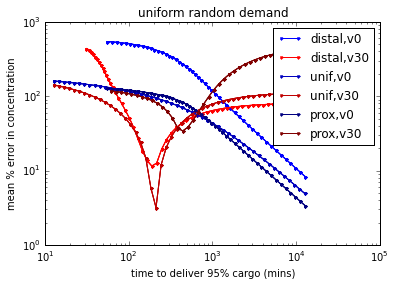

In [7]:
# Velocities at the soma (microns per minute)
velocities = [0.0,30.0]

# Size of each compartment in microns
cs = 8

# Compute bias terms
# /60 to convert seconds to minutes
# /cs the compartment size in microns
# /2 since velocity = a-b = (0.5+bias)-(0.5-bias) = 2*bias
bias_levels = [velocities[i]/60/cs/2 for i in range(len(velocities))]
colors = [(0,0,1),(1,0,0), \
          (0,0,0.75),(0.75,0,0), \
          (0,0,0.5),(0.5,0,0)]

plt.figure()
for _ in range(3):
    c = 0
    for p in ('dist','unif','prox'):
        for bias in bias_levels:
            tau,err = calc_tradeoff_curve(bias=bias,npts=50,diff_coeff=0.5,profile=p)
            plt.plot(tau/60,err,'.-',color=colors[c])
            c += 1
plt.xscale('log')
plt.yscale('log')
#plt.xlim([1e1,1e5])
#plt.ylim([1e0,1e3])
plt.xlabel('time to deliver 95% cargo (mins)')
plt.ylabel('mean % error in concentration')
plt.title('uniform random demand')
plt.legend(['distal,v0','distal,v30','unif,v0','unif,v30','prox,v0','prox,v30'])
plt.savefig('E-alternate.svg')